In [1]:
import pandas as pd
from six.moves import cPickle
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

# 1. Data Loading

Loading the review data file and business file

In [2]:
df_full = pd.read_csv('/Users/chipchop/Documents/SINA/yelp_academic_dataset_review.csv', low_memory=False)

In [3]:
df_full.head()

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
0,2aFiy99vNLklCx3T_tGS9A,0,2011-10-10,0,NxL8SIC5yqOdnlXCg18IBg,5.0,If you enjoy service by someone who is as comp...,review,0.0,KpkOkG6RIf4Ra25Lhhxf1A
1,2aFiy99vNLklCx3T_tGS9A,0,2010-12-29,0,pXbbIgOXvLuTi_SPs1hQEQ,5.0,After being on the phone with Verizon Wireless...,review,1.0,bQ7fQq1otn9hKX-gXRsrgA
2,2aFiy99vNLklCx3T_tGS9A,0,2011-04-29,0,wslW2Lu4NYylb1jEapAGsw,5.0,Great service! Corey is very service oriented....,review,0.0,r1NUhdNmL6yU9Bn-Yx6FTw
3,2LfIuF3_sX6uwe-IR-P0jQ,1,2014-07-14,0,GP6YEearUWrzPtQYSF1vVg,5.0,Highly recommended. Went in yesterday looking ...,review,0.0,aW3ix1KNZAvoM8q-WghA3Q
4,2LfIuF3_sX6uwe-IR-P0jQ,0,2014-01-15,0,25RlYGq2s5qShi-pn3ufVA,4.0,I walked in here looking for a specific piece ...,review,0.0,YOo-Cip8HqvKp_p9nEGphw


In [4]:
df_bus = pd.read_csv('/Users/chipchop/Documents/SINA/yelp_academic_dataset_business.csv')

In [5]:
print("Columns in business data file are:")
for i in df_bus.columns:
    print(i)

Columns in business data file are:
address
attribute_AcceptsInsurance
attribute_AgesAllowed
attribute_Alcohol
attribute_Ambience_casual
attribute_Ambience_classy
attribute_Ambience_divey
attribute_Ambience_hipster
attribute_Ambience_intimate
attribute_Ambience_romantic
attribute_Ambience_touristy
attribute_Ambience_trendy
attribute_Ambience_upscale
attribute_BYOB
attribute_BYOBCorkage
attribute_BestNights_friday
attribute_BestNights_monday
attribute_BestNights_saturday
attribute_BestNights_sunday
attribute_BestNights_thursday
attribute_BestNights_tuesday
attribute_BestNights_wednesday
attribute_BikeParking
attribute_BusinessAcceptsBitcoin
attribute_BusinessAcceptsCreditCards
attribute_BusinessParking_garage
attribute_BusinessParking_lot
attribute_BusinessParking_street
attribute_BusinessParking_valet
attribute_BusinessParking_validated
attribute_ByAppointmentOnly
attribute_Caters
attribute_CoatCheck
attribute_Corkage
attribute_DietaryRestrictions_dairy-free
attribute_DietaryRestriction

# 2. Data Exploration, Data Cleaning and Matrix Building 

## 2.a. Number of businesses in each city:

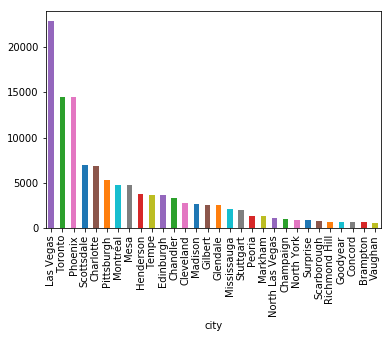

In [6]:
df_bus_groups = df_bus.groupby('city').count()
df_bus_city = df_bus_groups['name']
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted[:30].plot(kind = 'bar', color={'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'})

## 2.b. Different Type of Businesses and their Count:

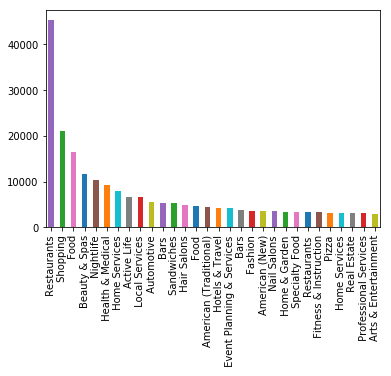

In [7]:
uniq_cat_dict = {}
for i in df_bus.categories:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar', color={'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'})

## 2.c. Business and City Ordered pairs and their count:

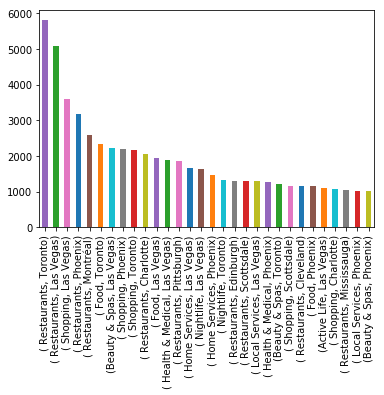

In [8]:
business_city = {}
n = len(df_bus)
for i in range(n):
    k1 = str(df_bus.categories.iloc[i]).split(',')
    k2 = df_bus.city.iloc[i]
    for j in k1:
        k = (j,k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar', color={'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'})

## Inferences from 2.a, 2.b and 2.c

It can be seen that most of the businesses listed on the Yelp are Restaurants, Shopping places and Recreational Centers. For this given data set (obtained from Yelp's Website), top cities with maximum businesses are Las Vegas, Phoenix, and Toronto.

## 2.d. Cleaning the review data

Dropping the unwanted columns like 'text': review text, 'useful': Number of people rated it useful, 'date',etc.
The columns left are 'user_id', 'business_id' and 'stars'.

In [9]:
df_reduced = df_full.drop(['useful','cool', 'date', 'funny'], axis = 1)
df_reduced.head()

,business_id,review_id,stars,text,type,user_id
0,2aFiy99vNLklCx3T_tGS9A,NxL8SIC5yqOdnlXCg18IBg,5.0,If you enjoy service by someone who is as comp...,review,KpkOkG6RIf4Ra25Lhhxf1A
1,2aFiy99vNLklCx3T_tGS9A,pXbbIgOXvLuTi_SPs1hQEQ,5.0,After being on the phone with Verizon Wireless...,review,bQ7fQq1otn9hKX-gXRsrgA
2,2aFiy99vNLklCx3T_tGS9A,wslW2Lu4NYylb1jEapAGsw,5.0,Great service! Corey is very service oriented....,review,r1NUhdNmL6yU9Bn-Yx6FTw
3,2LfIuF3_sX6uwe-IR-P0jQ,GP6YEearUWrzPtQYSF1vVg,5.0,Highly recommended. Went in yesterday looking ...,review,aW3ix1KNZAvoM8q-WghA3Q
4,2LfIuF3_sX6uwe-IR-P0jQ,25RlYGq2s5qShi-pn3ufVA,4.0,I walked in here looking for a specific piece ...,review,YOo-Cip8HqvKp_p9nEGphw


## 2.e. Merging the business data with the review data

Merging the business data and the review data on the 'business_id'. Information like 'city' of the business and 'categories' of the business were taken from the business data file.

In [10]:
df_merged = df_reduced.merge(df_bus[['city','categories', 'business_id']], how = 'outer', on= 'business_id')
df_merged.head()

,business_id,review_id,stars,text,type,user_id,city,categories
0,2aFiy99vNLklCx3T_tGS9A,NxL8SIC5yqOdnlXCg18IBg,5.0,If you enjoy service by someone who is as comp...,review,KpkOkG6RIf4Ra25Lhhxf1A,Phoenix,"IT Services & Computer Repair, Local Services,..."
1,2aFiy99vNLklCx3T_tGS9A,pXbbIgOXvLuTi_SPs1hQEQ,5.0,After being on the phone with Verizon Wireless...,review,bQ7fQq1otn9hKX-gXRsrgA,Phoenix,"IT Services & Computer Repair, Local Services,..."
2,2aFiy99vNLklCx3T_tGS9A,wslW2Lu4NYylb1jEapAGsw,5.0,Great service! Corey is very service oriented....,review,r1NUhdNmL6yU9Bn-Yx6FTw,Phoenix,"IT Services & Computer Repair, Local Services,..."
3,2LfIuF3_sX6uwe-IR-P0jQ,GP6YEearUWrzPtQYSF1vVg,5.0,Highly recommended. Went in yesterday looking ...,review,aW3ix1KNZAvoM8q-WghA3Q,Phoenix,"Antiques, Home & Garden, Home Decor, Shopping"
4,2LfIuF3_sX6uwe-IR-P0jQ,25RlYGq2s5qShi-pn3ufVA,4.0,I walked in here looking for a specific piece ...,review,YOo-Cip8HqvKp_p9nEGphw,Phoenix,"Antiques, Home & Garden, Home Decor, Shopping"


In [11]:
df_cleaned = df_merged.dropna()

## 2.f. Getting the top Business and City for which highest number of reviews are obtained

In [12]:
def topm_num_reviews_for_city_n_biz(df,m):
    business_city_count = {}
    n = len(df)
    for i in range(n):
        k1 = str(df.categories.iloc[i]).split(',')
        k2 = df.city.iloc[i]
        for j in k1:
            k = (j,k2)
            if k not in business_city_count.keys():
                business_city_count[k] = 1
            else:
                business_city_count[k] += 1
    business_city_count_series = pd.Series(business_city_count)
    business_city_count_series.sort_values(ascending = False, inplace = True)
    return business_city_count_series

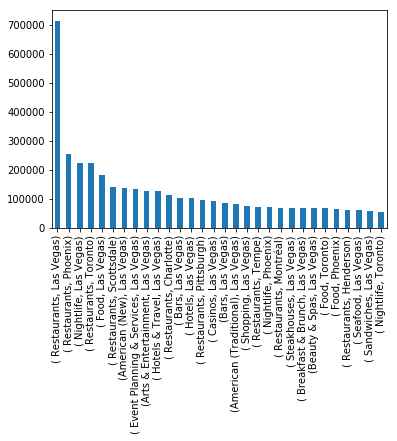

In [13]:
review_business_city = topm_num_reviews_for_city_n_biz(df_cleaned,10)
review_business_city[:30].plot(kind = 'bar')

In [ ]:
rest_phoenix_reviews = df_cleaned[(df_cleaned.city == 'Phoenix') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_phoenix_reviews.shape

In [ ]:
rest_toronto_reviews = df_cleaned[(df_cleaned.city == 'Toronto') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_toronto_reviews.shape

In [14]:
rest_reviews = df_cleaned[((df_cleaned.city == 'Phoenix')|(df_cleaned.city == 'Toronto')) & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_reviews.shape

(476693, 8)

In [15]:
rest_reviews.head()

,business_id,review_id,stars,text,type,user_id,city,categories
198,0BJK4_RQnNiiXJcYPEgG3w,asHvvC1mUN_hweRw8DeRkA,4.0,The service was friendly and attentive without...,review,2QhYG5gwEReX7qC_EE7jaA,Toronto,"Himalayan/Nepalese, Indian, Restaurants"
199,0BJK4_RQnNiiXJcYPEgG3w,3gdXLrmOWfriU8JCNBnjng,5.0,What everyone else said! I'd like to put a go...,review,puKCWAzXbY4QfpMBOkVEKg,Toronto,"Himalayan/Nepalese, Indian, Restaurants"
200,0BJK4_RQnNiiXJcYPEgG3w,vAeDysRFfOtk3wJSBhqbOg,5.0,"This place is great - nice food, not very expe...",review,MdjsjgFRXf1g5nIxSL-1zQ,Toronto,"Himalayan/Nepalese, Indian, Restaurants"
201,0BJK4_RQnNiiXJcYPEgG3w,TcRW-Sg7AvyN6RY_nNY9IA,2.0,so disappointed !\n\ni had fairly high hopes f...,review,goyBp2yzRfBRzfRVKy9t9Q,Toronto,"Himalayan/Nepalese, Indian, Restaurants"
202,0BJK4_RQnNiiXJcYPEgG3w,_fKKTE17IGF3rTbs3HEGmw,3.0,Pretty good nepalese food. The portions are a ...,review,X5whw8WcB8dVZGZ5vGnSLg,Toronto,"Himalayan/Nepalese, Indian, Restaurants"


In [16]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [17]:
def get_clean_df(df, min_user_review = 30, min_res_review = 0, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean_2 = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean_2

In [18]:
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [19]:
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    row = df['user_id'].astype('category', categories=unique_users).cat.codes
    col = df['business_id'].astype('category', categories=unique_bus).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [20]:
u_20_phx = get_sparse_matrix(get_clean_df(rest_reviews, min_user_review=20))
u_30_phx = get_sparse_matrix(get_clean_df(rest_reviews, min_user_review=30))
print(get_sparsity(u_20_phx))
print(get_sparsity(u_30_phx))
print(u_20_phx.shape)
print(u_30_phx.shape)

0.9947818075355228
0.9927689278438381
(3141, 8408)
(1797, 8155)


In [21]:
user_min_10_res = get_clean_df(rest_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Phoenix and Toronto: ", user_min_10_res.shape[0])

Number of Reviews for Restaurants in Phoenix and Toronto:  202982


In [22]:
# Creating X and Y for the classifier. X is the review text and Y is the rating
x = rest_reviews['text']
y = rest_reviews['stars']

In [23]:
import string
def text_preprocessing(text):
    no_punctuation = [ch for ch in text if ch not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [w for w in no_punctuation.split() if w.lower() not in stopwords.words('english')]

In [24]:
%%time
# Estimated time: 30 min

# Vectorization
# Converting each review into a vector using bag-of-words approach

from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(analyzer=text_preprocessing).fit(x)
x = vector.transform(x)

CPU times: user 2h 35min 54s, sys: 31min 1s, total: 3h 6min 55s
Wall time: 3h 6min 56s


In [25]:
# Spitting data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=0, shuffle =False)

# Building Multinomial Naive Bayes model and fit it to our training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
# Using our trained classifier to predict the ratings from text
# Testing our model on the test set

preds = classifier.predict(X_test)
print("Actual Ratings(Stars): ",end = "")
display(Y_test[:15])
print("Predicted Ratings: ",end = "")
print(preds[:15])

Actual Ratings(Stars): 

3341120    5.0
3341121    4.0
3341122    5.0
3341123    5.0
3341124    5.0
3341125    3.0
3341126    5.0
3341127    5.0
3341128    4.0
3341129    4.0
3341130    5.0
3341131    5.0
3341132    5.0
3341133    4.0
3341134    4.0
Name: stars, dtype: float64

Predicted Ratings: [5. 4. 5. 5. 3. 3. 5. 5. 5. 4. 5. 5. 5. 5. 4.]


In [27]:
# Accuracy of the model

from sklearn.metrics import accuracy_score
accuracy_score(Y_test, preds)

0.5824478964537073

In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print ('Precision: ' + str(precision_score(Y_test, preds, average='weighted')))
print ('Recall: ' + str(recall_score(Y_test,preds, average='weighted')))

Precision: 0.5737067845825599
Recall: 0.5824478964537073


In [29]:
# Evaluating the model
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 5703  1782   680   282   213]
 [ 1998  2734  3044   954   361]
 [  871  1319  5870  5602   990]
 [  466   389  2581 16267  9505]
 [  410   149   454  7759 24956]]


              precision    recall  f1-score   support

         1.0       0.60      0.66      0.63      8660
         2.0       0.43      0.30      0.35      9091
         3.0       0.46      0.40      0.43     14652
         4.0       0.53      0.56      0.54     29208
         5.0       0.69      0.74      0.72     33728

   micro avg       0.58      0.58      0.58     95339
   macro avg       0.54      0.53      0.53     95339
weighted avg       0.57      0.58      0.58     95339



In [30]:
# citation: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[ 5703  1782   680   282   213]
 [ 1998  2734  3044   954   361]
 [  871  1319  5870  5602   990]
 [  466   389  2581 16267  9505]
 [  410   149   454  7759 24956]]


<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.66 0.21 0.08 0.03 0.02]
 [0.22 0.3  0.33 0.1  0.04]
 [0.06 0.09 0.4  0.38 0.07]
 [0.02 0.01 0.09 0.56 0.33]
 [0.01 0.   0.01 0.23 0.74]]


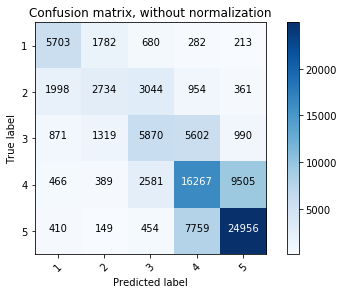

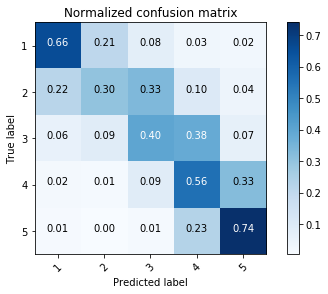

In [31]:
from sklearn import metrics
class_names = ['1','2','3','4','5']

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, preds
                                     )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [26]:
user_min_10_phoenix_res = get_clean_df(rest_phoenix_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Phoenix: ", user_min_10_phoenix_res.shape[0])
user_min_10_toronto_res = get_clean_df(rest_toronto_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Toronto: ", user_min_10_toronto_res.shape[0])

/Users/chipchop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/chipchop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Number of Reviews for Restaurants in Phoenix:  87610
Number of Reviews for Restaurants in Toronto:  114829


In [27]:
print("Unique Restaurants in Phoenix =",len(user_min_10_phoenix_res.business_id.unique()))
print("Unique Users in Phoenix =",len(user_min_10_phoenix_res.user_id.unique()))
print("Unique Restaurants in Toronto =",len(user_min_10_toronto_res.business_id.unique()))
print("Unique Users in Toronto =",len(user_min_10_toronto_res.user_id.unique()))

Unique Restaurants in Phoenix = 3053
Unique Users in Phoenix = 3829
Unique Restaurants in Toronto = 5672
Unique Users in Toronto = 4210


In [28]:
sm_user_10_phoenix_rest = get_sparse_matrix(user_min_10_phoenix_res)
print("Shape of ratings matrix for Restaurants in Phoenix =",sm_user_10_phoenix_rest.shape)
sm_user_10_toronto_rest = get_sparse_matrix(user_min_10_toronto_res)
print("Shape of ratings matrix for Restaurants in Toronto =",sm_user_10_toronto_rest.shape)

Shape of ratings matrix for Restaurants in Phoenix = (3829, 3053)
Shape of ratings matrix for Restaurants in Toronto = (4210, 5672)


/Users/chipchop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/Users/chipchop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  import sys


In [29]:
sparsity_phoenix = 1 - sm_user_10_phoenix_rest.nnz/(sm_user_10_phoenix_rest.shape[0]*sm_user_10_phoenix_rest.shape[1])
sparsity_toronto = 1 - sm_user_10_toronto_rest.nnz/(sm_user_10_toronto_rest.shape[0]*sm_user_10_toronto_rest.shape[1])
print("Sparsity of ratings matrix for Restaurants in Phoenix = ", sparsity_phoenix)
print("Sparsity of ratings matrix for Restaurants in Toronto = ", sparsity_toronto)

Sparsity of ratings matrix for Restaurants in Phoenix =  0.9925055199185419
Sparsity of ratings matrix for Restaurants in Toronto =  0.9951912382030829


In [30]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [31]:
sm_u_10_phx_res_train, sm_u_10_phx_res_val, sm_u_10_phx_res_test = train_val_test_split(sm_user_10_phoenix_rest)
sm_u_10_trt_res_train, sm_u_10_trt_res_val, sm_u_10_trt_res_test =  train_val_test_split(sm_user_10_toronto_rest)

/Users/chipchop/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [32]:
print(sm_u_10_phx_res_train.nnz, sm_u_10_phx_res_val.nnz, sm_u_10_phx_res_test.nnz)
print(sm_u_10_trt_res_train.nnz, sm_u_10_trt_res_val.nnz, sm_u_10_trt_res_test.nnz)

72294 7658 7658
97989 8420 8420


In [33]:
u_20_train, u_20_val, u_20_test = train_val_test_split(u_20_phx, num_review_val= 7, num_review_test= 3)